# Import packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

# Standard packages
import pandas as pd
import numpy as np
import pickle

# Sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# LGBM
from lightgbm import LGBMRegressor

# Keras
from keras.layers import (Input, Embedding, Flatten, Dot, Dense, Concatenate, 
                          Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D)
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model

# Plotly
import plotly.express as px

Using TensorFlow backend.
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pa/.virtualenvs/groover/lib/p

# Load data

In [2]:
sub = pd.read_csv('./data/raw/submission_history.csv')

# Load embeddings

In [3]:
embeddings_index = {}
with open('./cc.fr.300.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


# Vectorize text samples into a 2D integer tensor

In [4]:
texts = sub.track_info.fillna('Inconnu').values

MAX_NUM_WORDS = max([len(text) for text in texts])
MAX_SEQUENCE_LENGTH  = 440
EMBEDDING_DIM = 300

In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 38848 unique tokens.


# Prepare embedding matrix

In [6]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Define split and data

In [7]:
N_FOLDS = 5
RANDOM_SEED = 42

dataset = pd.read_csv('./data/preprocessed/merged_dataset.csv')
X = dataset.drop(columns=['id', 'track_id', 'band_id', 'influencer_id', 'score'])
y = dataset.score
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [8]:
band_data = X.filter(regex='_band')
influencer_data = X.filter(regex='_influencer')

influencer_kind = X.influencer_kind
i_kind_idx = X.columns.get_loc('influencer_kind')

b_data_idx = [X.columns.get_loc(c) for c in band_data]
i_data_idx = [X.columns.get_loc(c) for c in influencer_data]

# Define Model

In [10]:
def build_Text_model(
    i_emb_dim=16, 
    b_emb_dim=16, 
    kind_emb_dim=8,
    n_kernels=64,
    conv_dense=8,
    last_dense=16, 
    dropout=0.2,
    activation='relu'
):
    """
    Build Neural Network with NLP 1DCNN.
    """
    # Influencer embedding
    influencer_input = Input(shape=[influencer_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation=activation, name="Influencer-Embedding")(influencer_input)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(
        influencer_kind.nunique(), 
        kind_emb_dim, 
        name="Influencer-Kind-Embedding"
    )(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(name="Influencer-Full-Embedding", axis=-1)(
        [influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)]
    )
    
    # Band embedding
    band_input = Input(shape=[band_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation=activation, name="Band-Embedding")(band_input)
    
    # Track embedding
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(n_kernels, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(rate=dropout)(x)
    x = Conv1D(n_kernels, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=dropout)(x)
    seq_emb = Dense(conv_dense, activation='relu')(x)
    
    # Concatenate and create product
    concat = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding, seq_emb])
    dense = Dense(last_dense, activation=activation, name="Dense")(concat)
    
    # Dropout
    dropout = Dropout(rate=dropout)(dense)
    
    # Output
    output = Dense(1, activation=activation, name="Output")(dropout)
    band_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                 band_embedding)
    influencer_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                       influencer_full_emb)
    model = Model([influencer_input, band_input, influencer_kind_input, sequence_input], output)
    model.compile('adam', 'mean_squared_error')
    
    return model, band_embedding_model, influencer_embedding_model






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



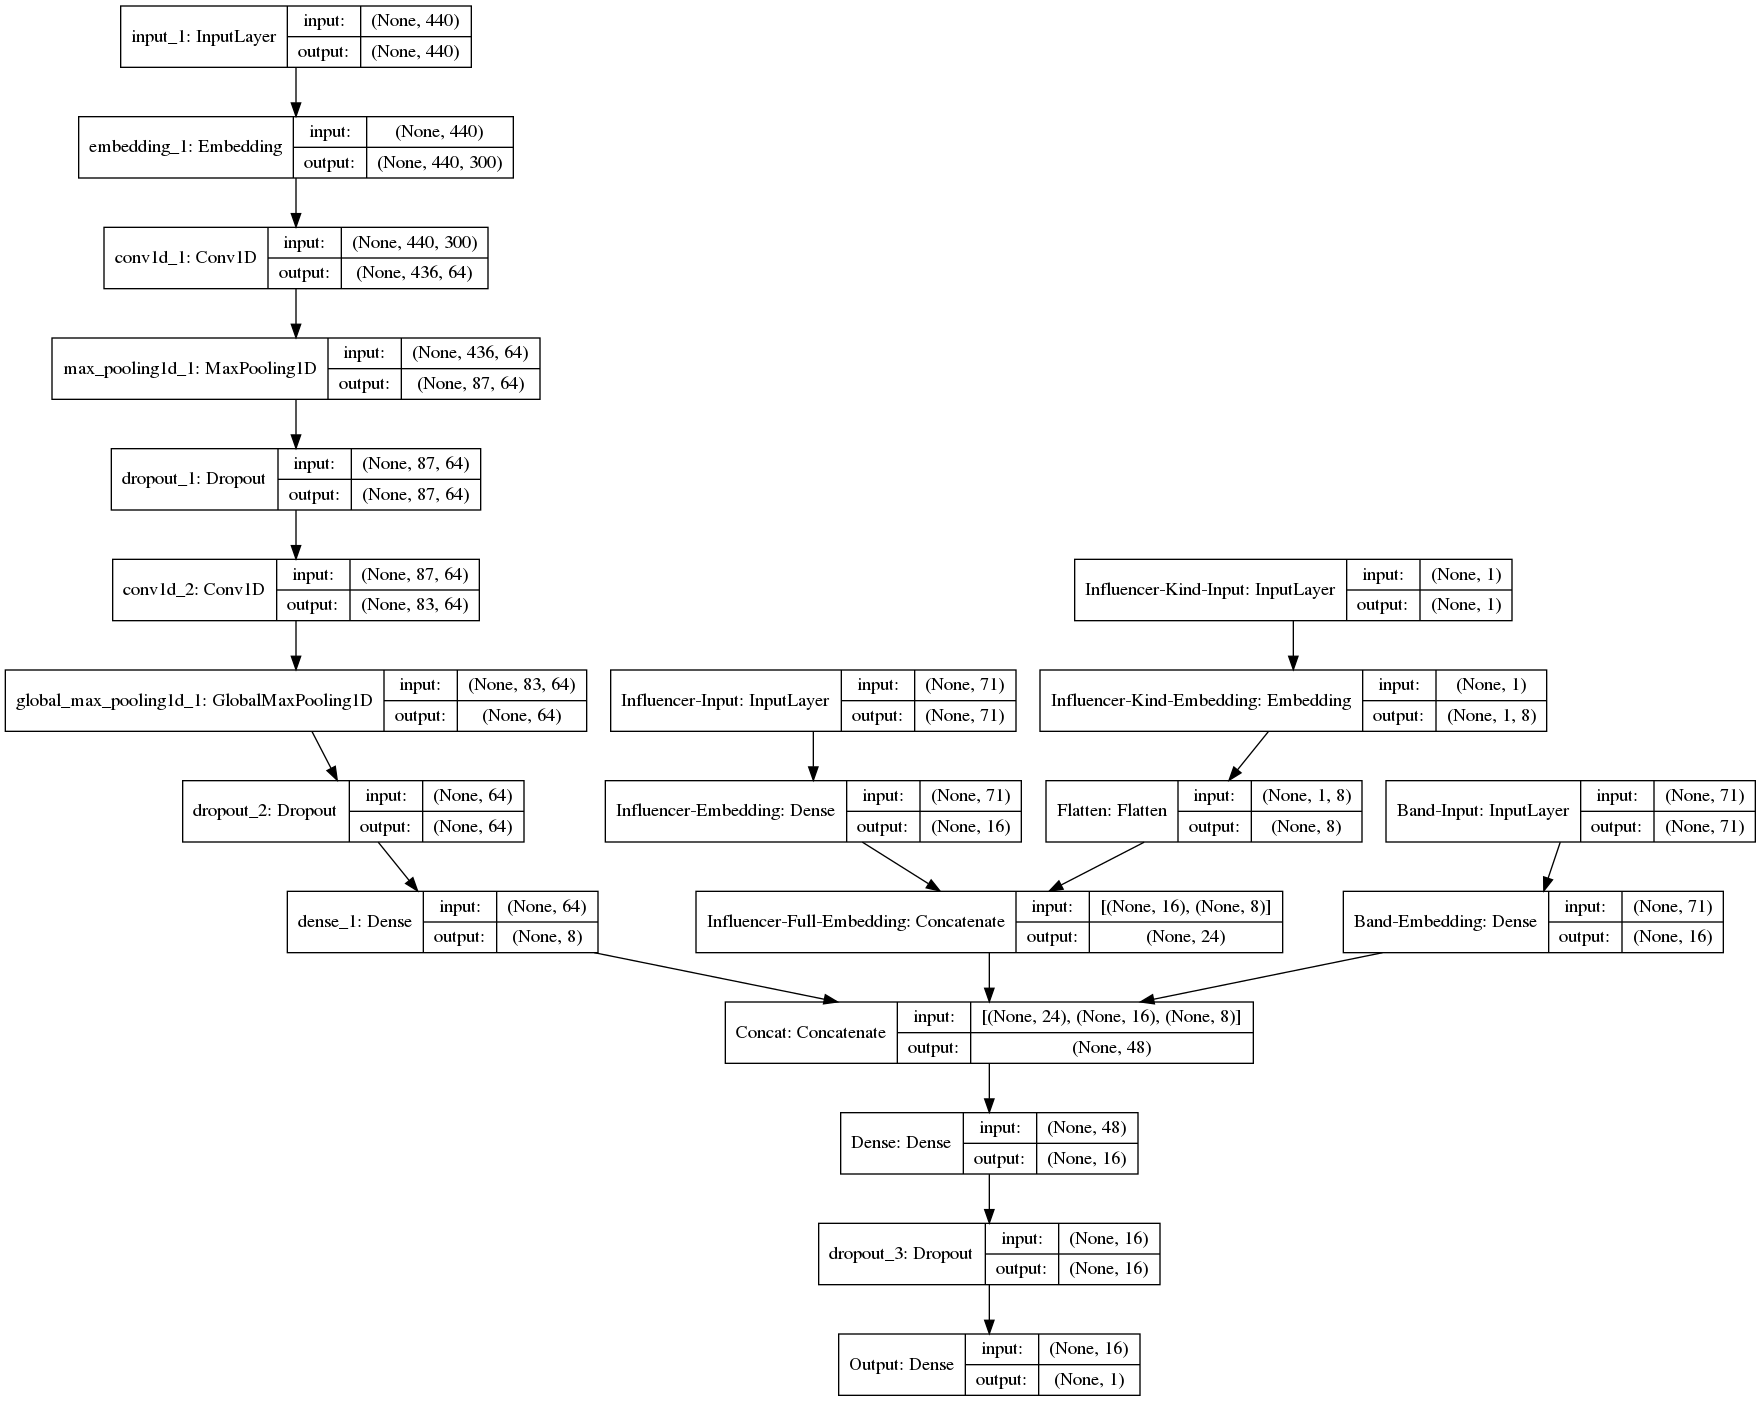

In [11]:
# Plot architecture
model, band_embedding_model, influencer_embedding_model = build_Text_model(dropout=0.2)
plot_model(model, to_file='Text_model_plot.png', show_shapes=True, show_layer_names=True)

# Train model

In [ ]:
EPOCHS = 200
PATIENCE = 20
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    docs_train, docs_test = data[train_index], data[test_index]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    docs_train, docs_valid = docs_train[tridx], docs_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_Text_model(dropout=0.2)
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5)
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx], docs_train], 
              y_train,
              validation_data=([X_valid[:, i_data_idx], 
                                X_valid[:, b_data_idx], 
                                X_valid[:, i_kind_idx],
                                docs_valid], 
                               y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es, reduce_lr],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx], docs_test]), 
        y_test
    ))

nn_score /= N_FOLDS

In [ ]:
print(nn_score)

In [ ]:
def build_NN_model(
    i_emb_dim=16, 
    b_emb_dim=16, 
    kind_emb_dim=8, 
    last_dense=16, 
    dropout=0.2,
    activation='relu'
):
    """
    Build simple MLP Neural Network.
    """
    # Influencer embedding
    influencer_input = Input(shape=[influencer_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation=activation, name="Influencer-Embedding")(influencer_input)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(
        influencer_kind.nunique(), 
        kind_emb_dim, 
        name="Influencer-Kind-Embedding"
    )(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(name="Influencer-Full-Embedding", axis=-1)(
        [influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)]
    )
    
    # Band embedding
    band_input = Input(shape=[band_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation=activation, name="Band-Embedding")(band_input)
    
    # Track embedding
    embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(64, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(rate=dropout)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=dropout)(x)
    seq_emb = Dense(16, activation='relu')(x)
    
    # Concatenate and create product
    concat = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding, seq_emb])
    dense = Dense(last_dense, activation=activation, name="Dense")(concat)
    
    # Dropout
    dropout = Dropout(rate=dropout)(dense)
    
    # Output
    output = Dense(1, activation=activation, name="Output")(dropout)
    band_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                 band_embedding)
    influencer_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                       influencer_full_emb)
    model = Model([influencer_input, band_input, influencer_kind_input, sequence_input], output)
    model.compile('adam', 'mean_squared_error')
    
    return model, band_embedding_model, influencer_embedding_model

In [ ]:
EPOCHS = 200
PATIENCE = 20
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    docs_train, docs_test = data[train_index], data[test_index]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    docs_train, docs_valid = docs_train[tridx], docs_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_NN_model(dropout=0.3)
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    # Reduce Learning Rate on Plateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5)
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx], docs_train], 
              y_train,
              validation_data=([X_valid[:, i_data_idx], 
                                X_valid[:, b_data_idx], 
                                X_valid[:, i_kind_idx],
                                docs_valid], 
                               y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es, reduce_lr],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx], docs_test]), 
        y_test
    ))

nn_score /= N_FOLDS

In [ ]:
print(nn_score)

In [ ]:
EPOCHS = 200
PATIENCE = 15
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    docs_train, docs_test = data[train_index], data[test_index]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    docs_train, docs_valid = docs_train[tridx], docs_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_NN_model(dropout=0.1)
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx], docs_train], 
              y_train,
              validation_data=([X_valid[:, i_data_idx], 
                                X_valid[:, b_data_idx], 
                                X_valid[:, i_kind_idx],
                                docs_valid], 
                               y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx], docs_test]), 
        y_test
    ))

nn_score /= N_FOLDS

In [ ]:
print(nn_score)